<a href="https://colab.research.google.com/github/vvmnnnkv/s4tf-fast-style-transfer/blob/master/Demo/Fast_Style_Transfer_with_S4TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Style Transfer 🎨 with S4TF 

Demo of fast style transfer model re-written in Swift for TensorFlow. [The model](https://github.com/vvmnnnkv/s4tf-fast-style-transfer.git) can be installed as SwiftPM package. Pre-trained [weights loader](https://github.com/vvmnnnkv/s4tf-model-import) is another standalone package (might be ditched in the future).

The model implementation and pre-trained weights (candy.pth) are borrowed from [Fast neural style]((https://github.com/pytorch/examples/tree/master/fast_neural_style) PyTorch example.

This demo uses some temporary solutions that should go away with the future versions of S4FT:
  * Pre-trained weights are [converted](https://github.com/vvmnnnkv/s4tf-fast-style-transfer/blob/master/Demo/weights/torch-convert.py) from pytorch format to numpy, and [loaded](https://github.com/vvmnnnkv/s4tf-model-import/blob/master/Sources/ImportableLayer/Numpy.swift) in Tensor using Python interop
  * Weights are [imported](https://github.com/vvmnnnkv/s4tf-model-import/blob/master/Sources/ImportableLayer/ImportableLayer.swift) into the model using KeyPathIterable in combination with reflection api 🙌
  * SwiftCV is used to load the image

NOTE: there's a problem with Colab packages installation, the first cell will fail on the first attempt. Restarting (not resetting!) the runtime and re-running it again helps.



In [1]:
// Install pre-compiled OpenCV 4.1.0 into Colab runtime
%system curl -sL https://github.com/vvmnnnkv/opencv-colab/raw/master/opencv4.tar.gz | tar zxf - -C / && ldconfig /opt/opencv-4.1.0/lib/ && ln -s /opt/opencv-4.1.0/lib/pkgconfig/opencv4.pc /usr/lib/pkgconfig/opencv4.pc

// Install SwiftCV package
%install-location $cwd/swift-packages
%install '.package(url: "https://github.com/vvmnnnkv/SwiftCV.git", .branch("master"))' SwiftCV
%install '.package(url: "https://github.com/vvmnnnkv/s4tf-fast-style-transfer.git", .branch("master"))' FastStyleTransfer
%install '.package(url: "https://github.com/vvmnnnkv/s4tf-model-import.git", .branch("master"))' ImportableLayer

ln: failed to create symbolic link '/usr/lib/pkgconfig/opencv4.pc': File exists
Installing packages:
	.package(url: "https://github.com/vvmnnnkv/SwiftCV.git", .branch("master"))
		SwiftCV
	.package(url: "https://github.com/vvmnnnkv/s4tf-fast-style-transfer.git", .branch("master"))
		FastStyleTransfer
	.package(url: "https://github.com/vvmnnnkv/s4tf-model-import.git", .branch("master"))
		ImportableLayer
With SwiftPM flags: []
Working in: /tmp/tmp8l0yttai/swift-install
[1/2] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[2/3] Merging module jupyterInstalledPackages
Initializing Swift...
Installation complete!


In [0]:
import Foundation
import FoundationNetworking
import TensorFlow
import SwiftCV
import FastStyleTransfer
import ImportableLayer 

/// Imaging capabilities
%include "EnableIPythonDisplay.swift"
import Python
let plt = Python.import("matplotlib.pyplot")
IPythonDisplay.shell.enable_matplotlib("inline")

// Display Tensor
func show_img<T>(_ img: Tensor<T>, _ w: Int = 8, _ h: Int = 6) where T: NumpyScalarCompatible {
    plt.figure(figsize: [w, h])
    plt.imshow(img.makeNumpyArray())
    plt.show()  
}

[240, 240, 3]


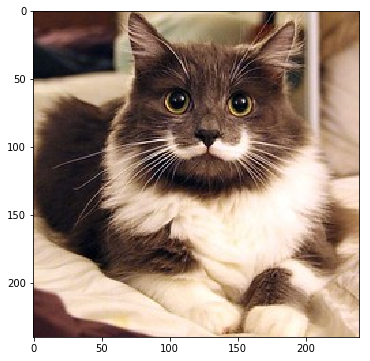

In [3]:
/// Load the hipster cat!
let imgUrl = "https://live.staticflickr.com/1624/23552974149_bd3ca7d0dd_m_d.jpg"
let imgContent = Data(contentsOf: URL(string: imgUrl)!)
var cvImg = imdecode(imgContent)
cvImg = cvtColor(cvImg, nil, ColorConversionCode.COLOR_BGR2RGB)
var image = Tensor<Float>(Tensor<UInt8>(cvMat: cvImg)!) / 255

print(image.shape)
show_img(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


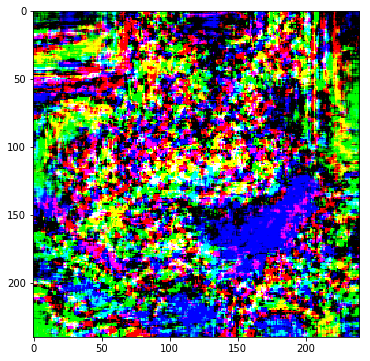

In [4]:
// Test with non-initialized model
var style = TransformerNet()
let out_random = style(image.expandingShape(at: 0))
show_img(out_random.squeezingShape(at: 0))

In [5]:
// Download pre-trained weights
let weightsUrl = "https://github.com/vvmnnnkv/s4tf-fast-style-transfer/raw/master/Demo/weights/candy.npz"
let weightsData = Data(contentsOf: URL(string: weightsUrl)!)
FileManager.default.createFile(atPath: "candy.npz", contents: weightsData)

// Import weights into the model, extend it with hacky importer
extension TransformerNet: ImportableLayer {}

// Map of model params to loaded params
// Names don't match exactly, and axes in filters need to be reversed
let map = [
    "conv1.conv2d.filter": ("conv1.conv2d.weight", [3, 2, 1, 0]),
    "conv2.conv2d.filter": ("conv2.conv2d.weight", [3, 2, 1, 0]),
    "conv3.conv2d.filter": ("conv3.conv2d.weight", [3, 2, 1, 0]),
    "deconv1.conv2d.filter": ("deconv1.conv2d.weight", [3, 2, 1, 0]),
    "deconv2.conv2d.filter": ("deconv2.conv2d.weight", [3, 2, 1, 0]),
    "deconv3.conv2d.filter": ("deconv3.conv2d.weight", [3, 2, 1, 0]),
    "res1.conv1.conv2d.filter": ("res1.conv1.conv2d.weight", [3, 2, 1, 0]),
    "res1.conv2.conv2d.filter": ("res1.conv2.conv2d.weight", [3, 2, 1, 0]),
    "res1.in1.scale": ("res1.in1.weight", nil),
    "res1.in1.offset": ("res1.in1.bias", nil),
    "res1.in2.scale": ("res1.in2.weight", nil),
    "res1.in2.offset": ("res1.in2.bias", nil),
    "res2.conv1.conv2d.filter": ("res2.conv1.conv2d.weight", [3, 2, 1, 0]),
    "res2.conv2.conv2d.filter": ("res2.conv2.conv2d.weight", [3, 2, 1, 0]),
    "res2.in1.scale": ("res2.in1.weight", nil),
    "res2.in1.offset": ("res2.in1.bias", nil),
    "res2.in2.scale": ("res2.in2.weight", nil),
    "res2.in2.offset": ("res2.in2.bias", nil),
    "res3.conv1.conv2d.filter": ("res3.conv1.conv2d.weight", [3, 2, 1, 0]),
    "res3.conv2.conv2d.filter": ("res3.conv2.conv2d.weight", [3, 2, 1, 0]),
    "res3.in1.scale": ("res3.in1.weight", nil),
    "res3.in1.offset": ("res3.in1.bias", nil),
    "res3.in2.scale": ("res3.in2.weight", nil),
    "res3.in2.offset": ("res3.in2.bias", nil),
    "res4.conv1.conv2d.filter": ("res4.conv1.conv2d.weight", [3, 2, 1, 0]),
    "res4.conv2.conv2d.filter": ("res4.conv2.conv2d.weight", [3, 2, 1, 0]),
    "res4.in1.scale": ("res4.in1.weight", nil),
    "res4.in1.offset": ("res4.in1.bias", nil),
    "res4.in2.scale": ("res4.in2.weight", nil),
    "res4.in2.offset": ("res4.in2.bias", nil),
    "res5.conv1.conv2d.filter": ("res5.conv1.conv2d.weight", [3, 2, 1, 0]),
    "res5.conv2.conv2d.filter": ("res5.conv2.conv2d.weight", [3, 2, 1, 0]),
    "res5.in1.scale": ("res5.in1.weight", nil),
    "res5.in1.offset": ("res5.in1.bias", nil),
    "res5.in2.scale": ("res5.in2.weight", nil),
    "res5.in2.offset": ("res5.in2.bias", nil),
    "in1.scale": ("in1.weight", nil),
    "in1.offset": ("in1.bias", nil),
    "in2.scale": ("in2.weight", nil),
    "in2.offset": ("in2.bias", nil),
    "in3.scale": ("in3.weight", nil),
    "in3.offset": ("in3.bias", nil),
    "in4.scale": ("in4.weight", nil),
    "in4.offset": ("in4.bias", nil),
    "in5.scale": ("in5.weight", nil),
    "in5.offset": ("in5.bias", nil),
]

style.unsafeImport(fromNumpyArchive: "candy.npz", map: map)

imported res5.in1.weight [128] -> res5.in1.scale [128]
imported res2.in2.weight [128] -> res2.in2.scale [128]
imported res3.in1.bias [128] -> res3.in1.offset [128]
imported res1.in2.weight [128] -> res1.in2.scale [128]
imported res3.conv2.conv2d.bias [128] -> res3.conv2.conv2d.bias [128]
imported deconv2.conv2d.bias [32] -> deconv2.conv2d.bias [32]
imported res1.conv2.conv2d.bias [128] -> res1.conv2.conv2d.bias [128]
imported res5.conv1.conv2d.weight [3, 3, 128, 128] -> res5.conv1.conv2d.filter [3, 3, 128, 128]
imported res1.in1.weight [128] -> res1.in1.scale [128]
imported conv3.conv2d.bias [128] -> conv3.conv2d.bias [128]
imported deconv1.conv2d.weight [3, 3, 128, 64] -> deconv1.conv2d.filter [3, 3, 128, 64]
imported res4.in2.bias [128] -> res4.in2.offset [128]
imported res1.in1.bias [128] -> res1.in1.offset [128]
imported in3.bias [128] -> in3.offset [128]
imported conv1.conv2d.weight [9, 9, 3, 32] -> conv1.conv2d.filter [9, 9, 3, 32]
imported res5.in1.bias [128] -> res5.in1.offset 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


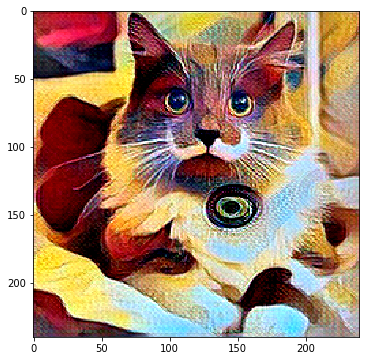

In [6]:
// Whoohoo!
let out_candy = style(image.expandingShape(at: 0))  / 255
show_img(out_candy.squeezingShape(at: 0))